# Regresión lineal para charn

### Imports

In [ ]:
# Generales y manejo de datos
import pandas as pd
import numpy as np
import os
import logging

# Visualización
import matplotlib.pyplot as plt

# Conexión a SQL Server
import pyodbc  

# Modelado y evaluación
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Métricas
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

## Df clientes

In [ ]:
# Configuración de logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Configuración de conexión a SQL Server LOCAL
LOCAL_SERVER = "localhost"
LOCAL_DATABASE = "master"
LOCAL_DRIVER = "{ODBC Driver 17 for SQL Server}"

local_conn_str = f"DRIVER={LOCAL_DRIVER};SERVER={LOCAL_SERVER};DATABASE={LOCAL_DATABASE};Trusted_Connection=yes;TrustServerCertificate=yes"

# Ruta a la carpeta con los archivos SQL
SQL_FOLDER_PATH = "src/sql/customer/"
SQL_FILE = "SQLQuery_Customer.sql"

# Leer la consulta desde el archivo SQL
with open(f"{SQL_FOLDER_PATH}{SQL_FILE}", "r", encoding="iso-8859-1") as file:
    query = file.read()

# Conectar a SQL Server y ejecutar la consulta
try:
    conn = pyodbc.connect(local_conn_str)
    df_customer = pd.read_sql(query, conn)
    conn.close()
    
    # Mostrar las primeras filas
    print(df_customer.head())
    
    logging.info("Consulta ejecutada exitosamente y convertida a DataFrame.")

except Exception as e:
    logging.error(f"Error al ejecutar la consulta: {e}")

C:\Users\aleja\AppData\Local\Temp\ipykernel_8472\2935947387.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_customer = pd.read_sql(query, conn)
2025-03-24 16:32:02,121 - INFO - Consulta ejecutada exitosamente y convertida a DataFrame.


   Customer_ID  Edad Fecha_nacimiento GENERO       CP        poblacion  \
0        78830    68       17/01/1956      M  23001.0             Jaén   
1        42247    38       09/01/1986      M  28813.0  Pozuelo del Rey   
2         9540    25       06/01/1999      F  19209.0             Quer   
3        38535    60       15/01/1964      F  20560.0            Oñati   
4        32738    37       09/01/1987      M   8860.0    Castelldefels   

     provincia STATUS_SOCIAL  RENTA_MEDIA_ESTIMADA  \
0         Jaén            NA                     0   
1       Madrid             D                 30078   
2  Guadalajara             D                 30050   
3     Gipuzkoa             U                     0   
4    Barcelona             D                 29014   

   ENCUESTA_ZONA_CLIENTE_VENTA  ...   Prod_date  Origen_Compra_ID    Origen  \
0                            0  ...  2023-04-09                 2    Tienda   
1                           98  ...  2021-09-10                 1  Inter

## Regresión lineal

### Preparación de los datos

In [ ]:
# 1. Agrupar todas las variables EXCEPTO PVP y PVP_x_Car_Age (que mantendremos a nivel transacción)
df_customer_agrupado = df_customer.groupby('Customer_ID').agg({
    'Margen_eur': 'mean',
    'Car_Age': 'mean',
    'Edad': 'mean',
    'Km_medio_por_revision': 'mean',
    'Margen_por_unidad': 'mean',
    'CHARN': 'max'
}).reset_index()

# 2. Merge con los valores ORIGINALES de PVP y PVP_x_Car_Age (sin agrupar)
df_customer_final = pd.merge(
    df_customer[['Customer_ID', 'PVP', 'PVP_x_Car_Age']],
    df_customer_agrupado,
    on='Customer_ID',
    how='right'
)

# 3. Limpieza datos
df_customer_final = df_customer_final.dropna()
df_customer_final = df_customer_final.replace([np.inf, -np.inf], np.nan).dropna()

# 4. Transformaciones
df_customer_final['log_PVP'] = np.log1p(df_customer_final['PVP'])
df_customer_final['sqrt_Car_Age'] = np.sqrt(df_customer_final['Car_Age'])

### Análisis exploratorio

CHARN                    1.000000
sqrt_Car_Age             0.256760
Km_medio_por_revision    0.231992
PVP_x_Car_Age            0.168534
log_PVP                 -0.091945
Name: CHARN, dtype: float64


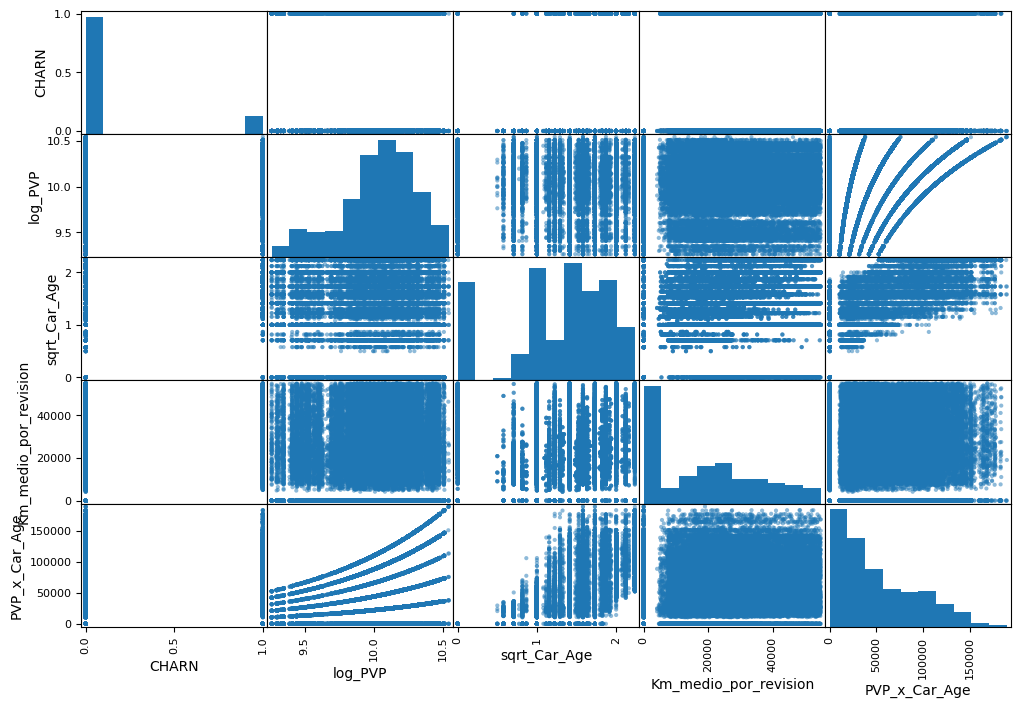

In [47]:
# Matriz de correlación con las nuevas variables
corr_cols = ['CHARN', 'log_PVP', 'sqrt_Car_Age', 'Km_medio_por_revision', 'PVP_x_Car_Age']
corr_matrix = df_customer_final[corr_cols].corr()
print(corr_matrix['CHARN'].sort_values(ascending=False))

# Visualización de relaciones
pd.plotting.scatter_matrix(df_customer_final[corr_cols], figsize=(12, 8))
plt.show()

### Preparación del modelo

In [48]:
# Definir variables independientes y dependiente
X = df_customer_final[['log_PVP', 'sqrt_Car_Age', 'Km_medio_por_revision', 'PVP_x_Car_Age']]
y = df_customer_final['CHARN']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Entrenamiento del modelo

In [49]:
# Modelo de regresión logística
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Métricas en entrenamiento
print("=== Métricas en Entrenamiento ===")
print(classification_report(y_train, model.predict(X_train)))
print("ROC AUC:", roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))

=== Métricas en Entrenamiento ===
              precision    recall  f1-score   support

           0       0.87      0.99      0.93     40266
           1       0.36      0.02      0.04      6173

    accuracy                           0.86     46439
   macro avg       0.61      0.51      0.48     46439
weighted avg       0.80      0.86      0.81     46439

ROC AUC: 0.7735835005974244


### Extracción de coeficientes Beta

In [50]:
# Extraer coeficientes
coeficientes = pd.DataFrame({
    'Variable': ['Intercepto'] + X.columns.tolist(),
    'Coeficiente': [model.intercept_[0]] + model.coef_[0].tolist(),
    'Odds_Ratio': np.exp([model.intercept_[0]] + model.coef_[0].tolist())
})

print("\nCoeficientes del Modelo:")
print(coeficientes.to_string(index=False))

# Guardar a CSV
output_path = 'docs/csv/coeficientes_logisticos_cltv.csv'
if os.path.exists(output_path):
    os.remove(output_path)
coeficientes.to_csv(output_path, index=False)


Coeficientes del Modelo:
             Variable  Coeficiente  Odds_Ratio
           Intercepto     0.034059    1.034646
              log_PVP    -0.499976    0.606545
         sqrt_Car_Age     1.861810    6.435373
Km_medio_por_revision     0.000029    1.000029
        PVP_x_Car_Age    -0.000007    0.999993


### Evaluación del modelo


=== Métricas en Test ===
              precision    recall  f1-score   support

           0       0.87      0.99      0.93     10059
           1       0.28      0.02      0.03      1551

    accuracy                           0.86     11610
   macro avg       0.57      0.51      0.48     11610
weighted avg       0.79      0.86      0.81     11610

ROC AUC: 0.7696431800282909


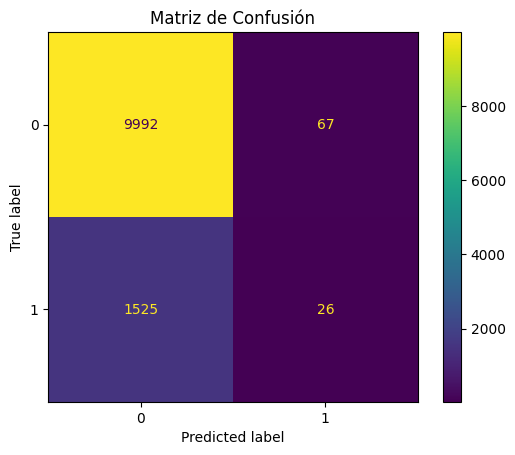

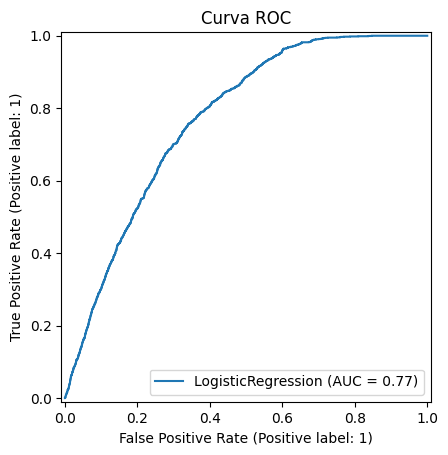

In [ ]:
# Evaluación en test
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\n=== Métricas en Test ===")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title("Matriz de Confusión")
plt.show()

# Curva ROC
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("Curva ROC")
plt.show()